In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

import sklearn
from sklearn.linear_model import LogisticRegressionCV    # 从线性回归模型中导入交叉验证逻辑回归
from sklearn.linear_model.coordinate_descent import warnings    # 导入忽略警告模块
from sklearn.model_selection import train_test_split     # 测试集和训练集划分
from sklearn.preprocessing import StandardScaler    # 标准化
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier    # KNN算法模块

### 数据预处理
    1、使用哑编码将非数值型数据转化为哑编码数据（one_hot）
    2、将预测结果划分为 0，1
    3、对数据进行归一化操作，将数据的方差尽可能减小

In [2]:
warnings.filterwarnings(action='ignore')

In [3]:
# 1.读取数据，重新指定列名
names = ['A%d' % i for i in range(1, 17)]
df = pd.read_csv('./datas/crx.data', header=None, names=names)
print('原数据数量：', df.shape)

# 2.删除数据中的控制
df = df.replace('?', np.nan).dropna(how='any')
print('过滤后的数据数量', df.shape)
print(df.head())

原数据数量： (690, 16)
过滤后的数据数量 (653, 16)
  A1     A2     A3 A4 A5 A6 A7    A8 A9 A10  A11 A12 A13    A14  A15 A16
0  b  30.83  0.000  u  g  w  v  1.25  t   t    1   f   g  00202    0   +
1  a  58.67  4.460  u  g  q  h  3.04  t   t    6   f   g  00043  560   +
2  a  24.50  0.500  u  g  q  h  1.50  t   f    0   f   g  00280  824   +
3  b  27.83  1.540  u  g  w  v  3.75  t   t    5   t   g  00100    3   +
4  b  20.17  5.625  u  g  w  v  1.71  t   f    0   f   s  00120    0   +


In [6]:
# 查看数据结构
df.apply(lambda x: print(x.value_counts()))

b    450
a    203
Name: A1, dtype: int64
22.67    9
20.67    6
22.50    6
18.83    6
19.17    6
23.58    6
25.00    6
23.08    5
27.83    5
27.67    5
23.25    5
23.00    5
20.42    5
24.50    5
41.17    4
22.92    4
20.00    4
28.58    4
22.08    4
20.75    4
34.17    4
27.25    4
35.17    4
26.17    4
33.17    4
26.67    4
32.33    4
25.17    4
23.50    4
24.75    4
        ..
43.00    1
50.25    1
28.33    1
56.83    1
17.42    1
69.17    1
39.00    1
39.33    1
60.92    1
26.83    1
41.92    1
60.58    1
38.33    1
21.42    1
29.17    1
27.17    1
31.75    1
40.83    1
36.58    1
46.00    1
15.17    1
15.75    1
38.42    1
41.75    1
50.75    1
48.25    1
26.33    1
25.50    1
33.00    1
30.75    1
Name: A2, Length: 340, dtype: int64
2.500     19
1.500     19
3.000     18
0.750     16
1.250     16
0.500     14
0.000     13
5.000     13
6.500     12
1.750     11
10.000    10
0.585      9
4.000      9
1.000      9
11.000     9
2.000      9
11.500     8
0.375      8
0.835      8
0.165

A1     None
A2     None
A3     None
A4     None
A5     None
A6     None
A7     None
A8     None
A9     None
A10    None
A11    None
A12    None
A13    None
A14    None
A15    None
A16    None
dtype: object

In [4]:
def one_hot(value, value_list):
    """
    将数据转变为one_hot编码
    """
    assert type(value) == str, 'value must be string'
    assert type(value_list) == list or tuple, 'value_list must be list'
    return [1 if value==i else 0 for i in value_list]

In [5]:
# 数据处理函数
def parsedata(ser):
    """
    对所有数据进行处理
    """
    # 创建列表存储编码后的数据
    result = []
    
    for i in one_hot(ser['A1'], ('a', 'b')):
        result.append(i)
        
    result.append(float(ser['A2']))
    result.append(float(ser['A3']))
    
    for i in one_hot(ser['A4'], ('u', 'y', 'l')):
        result.append(i)
        
    A5 = ('g', 'p', 'gg')
    for i in one_hot(ser['A5'], A5):
        result.append(i)
    
    A6 = ('c', 'q', 'w', 'i', 'aa', 'ff', 'k', 'cc', 'm', 'x', 'd', 'e', 'j', 'r')
    for i in one_hot(ser['A6'], A6):
        result.append(i)
        
    A7 = ('v', 'h', 'ff', 'bb', 'j', 'z', 'dd', 'n', 'o')
    for i in one_hot(ser['A7'], A7):
        result.append(i)
        
    result.append(float(ser['A8']))
    
    for i in one_hot(ser['A9'], ('t', 'f')):
        result.append(i)
        
    for i in one_hot(ser['A10'], ('f', 't')):
        result.append(i)
        
    result.append(float(ser['A11']))
    
    for i in one_hot(ser['A12'], ('f', 't')):
        result.append(i)
    
    for i in one_hot(ser['A13'], ('g', 's', 'p')):
        result.append(i)
    
    result.append(float(ser['A14']))
    result.append(float(ser['A15']))
    
    A16 = ser['A16']
    if A16 == '+':
        result.append(1)
    else:
        result.append(0)
    return result

In [6]:
# 新建dataframe 的列名
idx_list = [
    'A1_1', 'A1_2',
    'A2', 'A3',
    'A4_1', 'A4_2', 'A4_3',
    'A5_1', 'A5_2', 'A5_3',
    'A6_1', 'A6_2', 'A6_3', 'A6_4', 'A6_5', 'A6_6', 'A6_7', 'A6_8', 'A6_9',
    'A6_10', 'A6_11', 'A6_12', 'A6_13', 'A6_14',
    'A7_1', 'A7_2', 'A7_3', 'A7_4', 'A7_5', 'A7_6', 'A7_7', 'A7_8', 'A7_9',
    'A8',
    'A9_1', 'A9_2', 
    'A10_1', 'A10_2',
    'A11', 
    'A12_1', 'A12_2', 
    'A13_1', 'A13_2', 'A13_3', 
    'A14', 'A15', 'A16'
]
data = df.apply(lambda x: pd.Series(parsedata(x), index=idx_list), axis=1)

In [51]:
data.head(10).T

,0,1,2,3,4,5,6,7,8,9
A1_1,0.00,1.00,1.0,0.00,0.000,0.00,0.00,1.000,0.00,0.000
A1_2,1.00,0.00,0.0,1.00,1.000,1.00,1.00,0.000,1.00,1.000
A2,30.83,58.67,24.5,27.83,20.170,32.08,33.17,22.920,54.42,42.500
A3,0.00,4.46,0.5,1.54,5.625,4.00,1.04,11.585,0.50,4.915
A4_1,1.00,1.00,1.0,1.00,1.000,1.00,1.00,1.000,0.00,0.000
A4_2,0.00,0.00,0.0,0.00,0.000,0.00,0.00,0.000,1.00,1.000
A4_3,0.00,0.00,0.0,0.00,0.000,0.00,0.00,0.000,0.00,0.000
A5_1,1.00,1.00,1.0,1.00,1.000,1.00,1.00,1.000,0.00,0.000
A5_2,0.00,0.00,0.0,0.00,0.000,0.00,0.00,0.000,1.00,1.000
A5_3,0.00,0.00,0.0,0.00,0.000,0.00,0.00,0.000,0.00,0.000


In [7]:
# 数据处理
X = data[idx_list[0:-1]]
Y = data[idx_list[-1]]

# 划分训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=10)

In [8]:
# 数据标准化
ss = StandardScaler()     #实例化对象

X_train = ss.fit_transform(X_train)     # 训练并进行标准化转换
x_test = ss.transform(X_test)    # 测试集转化


In [9]:
# 构建logistics 模型
lr = LogisticRegressionCV(
    Cs=np.logspace(-4, 1, 50),    # 惩罚项系数，即l1
    fit_intercept=True,    # 是否加载截距
    penalty='l2',    # 使用l2正则
    solver='lbfgs',
    tol=0.01,
    multi_class='ovr'
)
lr.fit(X_train, Y_train)

LogisticRegressionCV(Cs=array([1.00000000e-04, 1.26485522e-04, 1.59985872e-04, 2.02358965e-04,
       2.55954792e-04, 3.23745754e-04, 4.09491506e-04, 5.17947468e-04,
       6.55128557e-04, 8.28642773e-04, 1.04811313e-03, 1.32571137e-03,
       1.67683294e-03, 2.12095089e-03, 2.68269580e-03, 3.39322177e-03,
       4.29193426e-03, 5.42867544e-03, 6.86648845e-03, 8.68511374e-03,
       1.09854114e-02, 1.38...
       1.20679264e+00, 1.52641797e+00, 1.93069773e+00, 2.44205309e+00,
       3.08884360e+00, 3.90693994e+00, 4.94171336e+00, 6.25055193e+00,
       7.90604321e+00, 1.00000000e+01]),
                     class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.01, verbose=0)

In [10]:
## Logistic算法效果输出
lr_r = lr.score(X_train, Y_train)
print ("Logistic算法R值（训练集上的准确率）：", lr_r)
print ("Logistic算法稀疏化特征比率：%.2f%%" % (np.mean(lr.coef_.ravel() == 0) * 100))
print ("Logistic算法参数：",lr.coef_)
print ("Logistic算法截距：",lr.intercept_)

Logistic算法R值（训练集上的准确率）： 0.8916155419222904
Logistic算法稀疏化特征比率：2.17%
Logistic算法参数： [[-0.00204634  0.00204634  0.05847921  0.06397592  0.03337266 -0.03849049
   0.04741426  0.03337266 -0.03849049  0.04741426 -0.00334468  0.03544344
   0.06190383 -0.06884002 -0.0126843  -0.09265684 -0.04642208  0.05298326
  -0.00190935  0.0848905  -0.01048096  0.02695163 -0.00694843  0.0072973
   0.0004776   0.07415021 -0.08089174 -0.04081777  0.02939837  0.01702362
   0.00121337 -0.01329316 -0.01544586  0.11973497  0.36379357 -0.36379357
  -0.15339951  0.15339951  0.17160498  0.0045473  -0.0045473   0.02997018
  -0.02997018  0.         -0.04890353  0.10973456]]
Logistic算法截距： [-0.29251795]


In [11]:
# 查看测试集的预测结果
lr_y_predict = lr.predict(X_test)
print(lr_y_predict)

# 查看算法结果的概率值
print(lr.predict_proba(X_test))
print(lr.predict_log_proba(X_test))

[0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0.]
[[7.86295178e-01 2.13704822e-01]
 [9.92415046e-01 7.58495408e-03]
 [9.83927413e-01 1.60725871e-02]
 [1.00000000e+00 3.14420621e-11]
 [2.42399986e-03 9.97576000e-01]
 [9.98510102e-01 1.48989766e-03]
 [9.99995025e-01 4.97484840e-06]
 [0.00000000e+00 1.00000000e+00]
 [3.81916720e-14 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [8.34744725e-01 1.65255275e-01]
 [0.00000000e+00 1.00000000e+00]
 [9.86881900e-01 1.31181004e-02]
 [9.99996664e-01 3.33575948e-06]
 [0.00000000e+00 1.00000000e+00]
 [1.0

In [12]:
# 使用KNN算法进行预测
knn = KNeighborsClassifier(n_neighbors=20, algorithm='kd_tree', weights='distance')
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='distance')

In [13]:
knn_r = knn.score(X_train, Y_train)
print('使用knn算法在训练集上的R值，', knn_r)

使用knn算法的R值， 1.0


In [15]:
# 使用knn预测结果
knn_y_predict = knn.predict(X_test)
knn_r_test = knn.score(X_test, Y_test)
print('使用knn算法在测试集上的R值，', knn_r_test)

使用knn算法在测试集上的R值， 0.6280487804878049


In [17]:
# 更改设置防止中文乱码
from matplotlib.font_manager import FontProperties
mpl.rcParams['font.sans-serif'] = ['Heiti']
mpl.rcParams['axes.unicode_minus'] = False

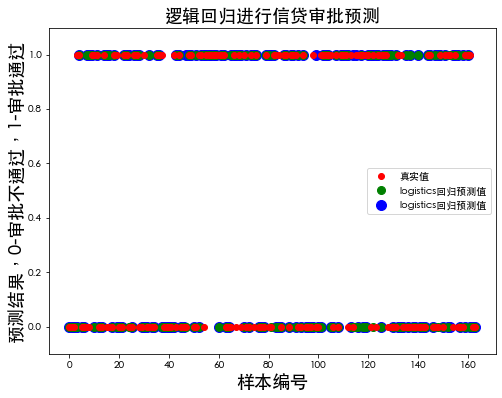

In [18]:
x_len = range(len(X_test))
plt.figure(facecolor='w', figsize=(8, 6))
plt.ylim(-0.1, 1.1)
plt.plot(x_len, Y_test, 'ro', markersize='6', zorder=3, label=u'真实值')
plt.plot(x_len, lr_y_predict, 'go', markersize='8', zorder=2, label=u'logistics回归预测值')
plt.plot(x_len, knn_y_predict, 'bo', markersize='10', zorder=1, label=u'logistics回归预测值')


plt.legend(loc='center right')
plt.title('逻辑回归进行信贷审批预测', fontsize=18)
plt.xlabel('样本编号', fontsize=18)
plt.ylabel('预测结果，0-审批不通过，1-审批通过', fontsize=18)
plt.show()

In [49]:
print(mpl.matplotlib_fname())

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc


.Aqua Kana
.Arabic UI Display
.Arabic UI Text
.Helvetica Neue DeskInterface
.Keyboard
.LastResort
.SF Compact Display
.SF Compact Display
.SF Compact Display
.SF Compact Display
.SF Compact Display
.SF Compact Display
.SF Compact Display
.SF Compact Display
.SF Compact Display
.SF Compact Rounded
.SF Compact Rounded
.SF Compact Rounded
.SF Compact Rounded
.SF Compact Rounded
.SF Compact Rounded
.SF Compact Rounded
.SF Compact Rounded
.SF Compact Rounded
.SF Compact Text
.SF Compact Text
.SF Compact Text
.SF Compact Text
.SF Compact Text
.SF Compact Text
.SF Compact Text
.SF Compact Text
.SF Compact Text
.SF Compact Text
.SF Compact Text
.SF Compact Text
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Display Condensed
.SF NS Rounded
.SF NS Symbols
.SF NS Symbols
.SF NS Symbols
.SF NS Symbols
.SF NS Symbols
.SF NS Symbols
.SF NS S